# Clustering

## Methods

For our analysis below, we will be using a combined data set containing occupations, employment rates, gender proportions, and annual wages from the Bureau of Labor Statistics. We will perform three clustering methods: K-Means, DBSCAN, and Hierarchical (Agglomerative).

### Imports


In [30]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

## Data Selection


In [31]:
df = pd.read_csv('../../../data/01-modified-data/occupations_detailed_(employment_by_sex_and_wage).csv')

## drop unneeded column created from read_csv
df = df.iloc[:, 1:]

In [32]:
## reorder columns
df = df[['TOT_EMP', 'A_MEAN', 'Women (%)', 'Men (%)', 'Target', 'Target_Num', 'OCC_TITLE']]

## rename columns
df = df.rename(columns={'TOT_EMP':'Total Employment', 'A_MEAN':'Mean Annual Wage'})

## Feature Selection

As we can see, we have a heavily imbalanced data set.


In [33]:
df['Target'].value_counts(ascending=True)

Farming, Fishing, and Forestry Occupations                     1
Life, Physical, and Social Science Occupations                 2
Educational Instruction and Library Occupations                2
Legal Occupations                                              4
Healthcare Support Occupations                                 6
Building and Grounds Cleaning and Maintenance Occupations      6
Protective Service Occupations                                 7
Architecture and Engineering Occupations                       9
Community and Social Service Occupations                      10
Construction and Extraction Occupations                       10
Food Preparation and Serving Related Occupations              10
Personal Care and Service Occupations                         10
Installation, Maintenance, and Repair Occupations             11
Computer and Mathematical Occupations                         11
Arts, Design, Entertainment, Sports, and Media Occupations    13
Sales and Related Occupat

We perform some pre-processing to ensure the best clustering results. First, we isolate the features in our data set, which are Total Employment, Average Annual Wage, % of Women in the occupation, and % of Men in the occupation.


In [34]:
X = df.iloc[:, 0:4]

### Normalization

Since our predictors (X) consist of values that are outside the ideal range of [0, 1], we first normalize our data to bring all the predictor values into a space that is unitless. This transformation of data brings everything to a similar scale, which makes it easier for the classifiers to "learn" the data. 


In [35]:
X=0.1+(X-np.min(X,axis=0))/(np.max(X,axis=0)-np.min(X,axis=0))

### Correlation

The correlation output below shows an inverse correlation (= -1) between % of Women in the occupation and % of Men in the occupation (which is to be expected). Since we need to maintain independence among the predictor variables, I will drop % of Men in the occupation (Men (%)) to prevent the model from overcounting similar features.


In [36]:
corr = X.corr()
print(corr)	

                  Total Employment  Mean Annual Wage  Women (%)   Men (%)
Total Employment          1.000000         -0.102376   0.071952 -0.071952
Mean Annual Wage         -0.102376          1.000000  -0.201373  0.201373
Women (%)                 0.071952         -0.201373   1.000000 -1.000000
Men (%)                  -0.071952          0.201373  -1.000000  1.000000


The correlation matrix heatmap below as well as the multivariable pair plots reflect the previous correlation output. Again, there is an inverse correlation between employment percent relative standard error (EMP_PRSE) and mean annual salary percent relative standard error (MEAN_PRSE).


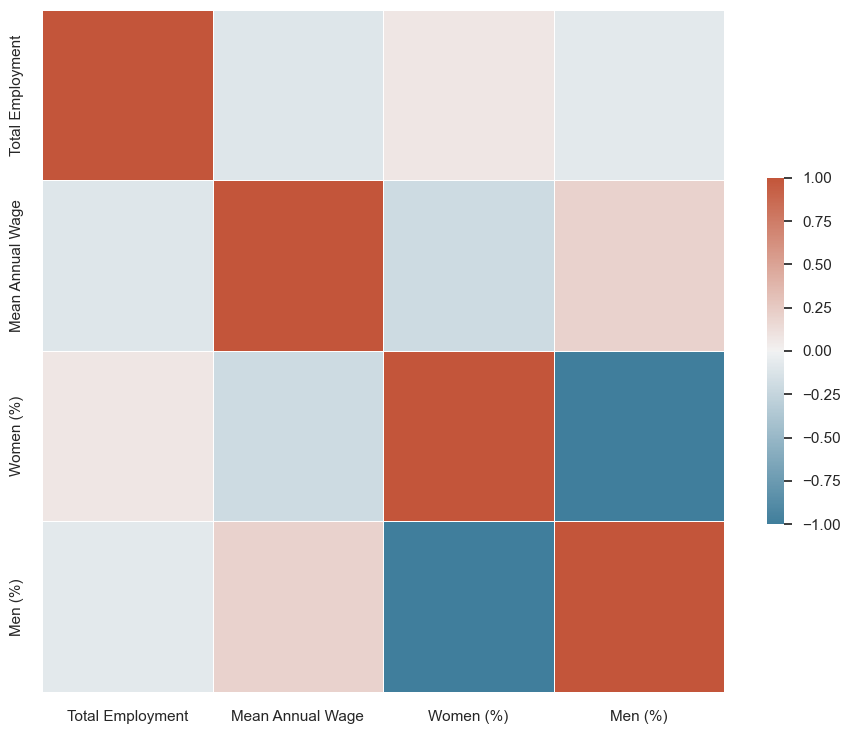

In [37]:
sns.set_theme(style="white")
f, ax = plt.subplots(figsize=(11, 9))  # Set up the matplotlib figure
cmap = sns.diverging_palette(230, 20, as_cmap=True) 	# Generate a custom diverging colormap
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr,  cmap=cmap, vmin=-1, vmax=1, center=0,
        square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show();

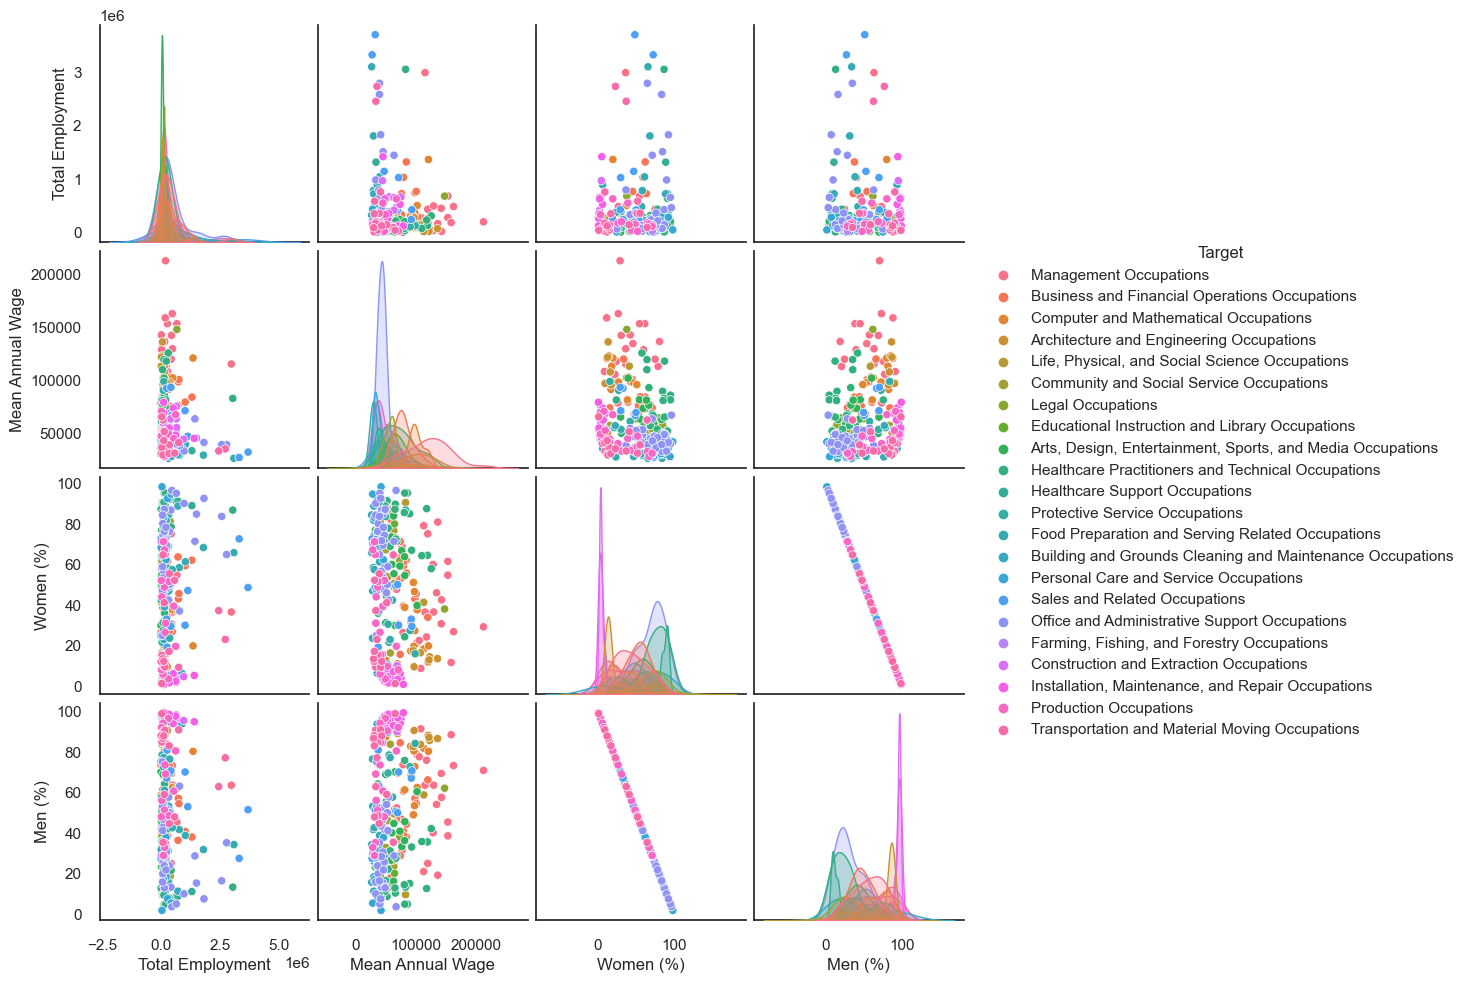

In [38]:
sns.pairplot(df.iloc[:,0:5], hue='Target')
plt.show()

In [39]:
X.drop(columns=['Men (%)'], inplace=True)

## Model Tuning

### Pre-processing and Helper Functions


In [40]:
X = np.ascontiguousarray(X)
NDIM = X.shape[1]

In [41]:
## helper functions
import sklearn.cluster

# THIS WILL ITERATE OVER ONE HYPER-PARAMETER (GRID SEARCH) 
# AND RETURN THE CLUSTER RESULT THAT OPTIMIZES THE SILHOUETTE SCORE
def maximize_silhouette(X,algo="birch",nmax=15,i_plot=False):
    # LOOP OVER HYPER-PARAM
    params=[]; sil_scores=[]
    name = algo
    sil_max=-10
    for param in range(2,nmax+1):
        if(algo=="birch"):
            name = "Birch"
            model = sklearn.cluster.Birch(n_clusters=param).fit(X)
            labels=model.predict(X)

        if(algo=="ag"):
            name = "Agglomerative"
            model = sklearn.cluster.AgglomerativeClustering(n_clusters=param, linkage='ward').fit(X)
            labels=model.labels_

        if(algo=="dbscan"):
            name = "DBSCAN"
            param=0.5*(param-1)
            model = sklearn.cluster.DBSCAN(eps=param).fit(X)
            labels=model.labels_

        if(algo=="kmeans"):
            name = "K-Means"
            model = sklearn.cluster.KMeans(n_clusters=param, random_state=1234).fit(X)
            labels=model.predict(X)
            
        if(algo=="ms"):
            name = "Mean Shift"
            model = sklearn.cluster.MeanShift().fit(X)
            labels=model.predict(X)

        try:
            sil_scores.append(sklearn.metrics.silhouette_score(X,labels))
            params.append(param)
        except:
            continue 
        
        if(sil_scores[-1]>sil_max):
            opt_param=param
            sil_max=sil_scores[-1]
            opt_labels=labels

    print("OPTIMAL PARAMETER =",opt_param)
    print("Silhouette Coefficient =",sil_max)

    if(i_plot):
        fig, ax = plt.subplots()
        ax.set_title("Silhouette Scores based on # of Clusters (%s)" % name)
        ax.plot(params, sil_scores, "-o")  
        ax.set(xlabel='Hyper-parameter', ylabel='Silhouette')
        plt.show()

    return opt_labels

In [42]:
def plot(x,opt_labels,title=''):
	if(NDIM==2):
		fig, ax = plt.subplots()
		sp=ax.scatter(x[:,0], x[:,1],c=opt_labels,marker=".", cmap="viridis")
		plt.colorbar(sp)

	if(NDIM==3):
		fig = plt.figure()
		ax = fig.add_subplot(projection='3d')
		sp=ax.scatter(x[:,0],x[:,1],x[:,2],c=opt_labels,marker=".", cmap="viridis")
		plt.colorbar(sp)

	#DO PCA TO VISUALIZE
	if(NDIM>3):
		from sklearn.decomposition import PCA
		pca = PCA(n_components=3)
		pca.fit(x)
		Y=pca.fit_transform(x)
		fig = plt.figure()
		ax = fig.add_subplot(projection='3d')
		sp=ax.scatter(Y[:,0],Y[:,1],Y[:,2],c=opt_labels,marker=".", cmap="viridis")
		plt.colorbar(sp)
	plt.title(title)
	plt.show()

In [43]:
## ref: https://notebook.community/DistrictDataLabs/yellowbrick/examples/gokriznastic/Iris%20-%20clustering%20example
from yellowbrick.cluster import SilhouetteVisualizer

def plot_silhouette(X,nmax=10):
    for param in range(2,nmax+1):
        model = sklearn.cluster.KMeans(n_clusters=param, random_state=1234).fit(X)
        silhouette = SilhouetteVisualizer(model)
        silhouette.fit(X)
        silhouette.show()  

## K-Means

### Hyperparameter Tuning 

The plot below shows the silhouette coefficient for varying numbers of clusters. The silhouette coefficient peaks at k=3, which would be our optimal number of clusters.


c:\anaconda\envs\ANLY501\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\anaconda\envs\ANLY501\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\anaconda\envs\ANLY501\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\anaconda\envs\ANLY501\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Window

OPTIMAL PARAMETER = 3
Silhouette Coefficient = 0.4660805083484633


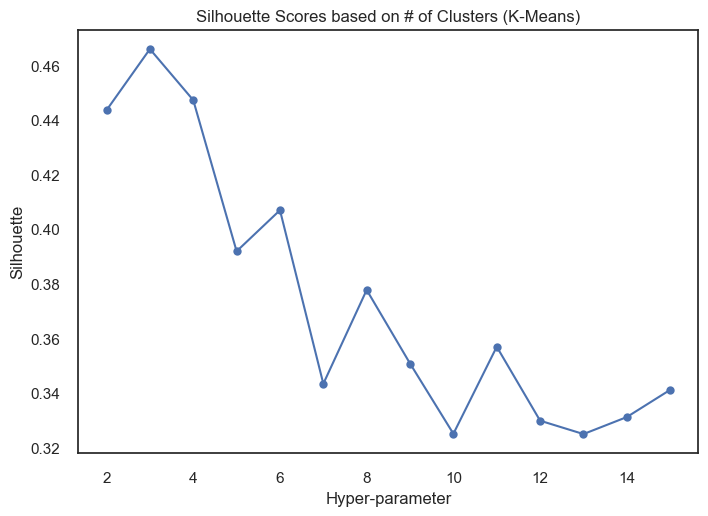

In [44]:
# KMEANS
opt_labels=maximize_silhouette(X,algo="kmeans",i_plot=True)

The silhouette plots below also show similar results with the silhouette scores peaking when k=3.


c:\anaconda\envs\ANLY501\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


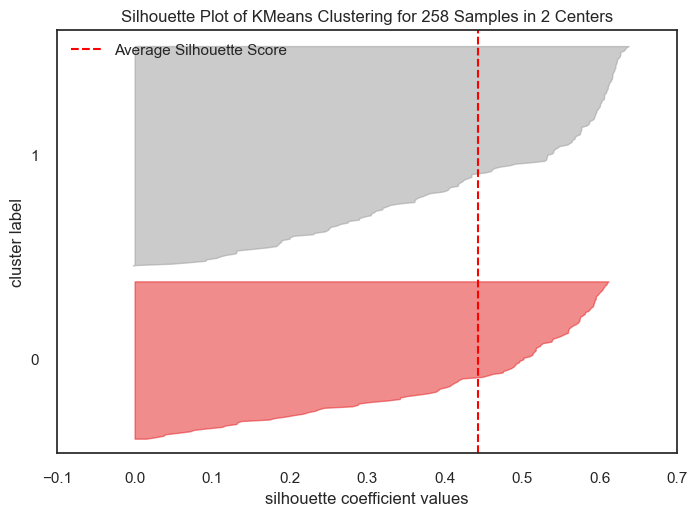

c:\anaconda\envs\ANLY501\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


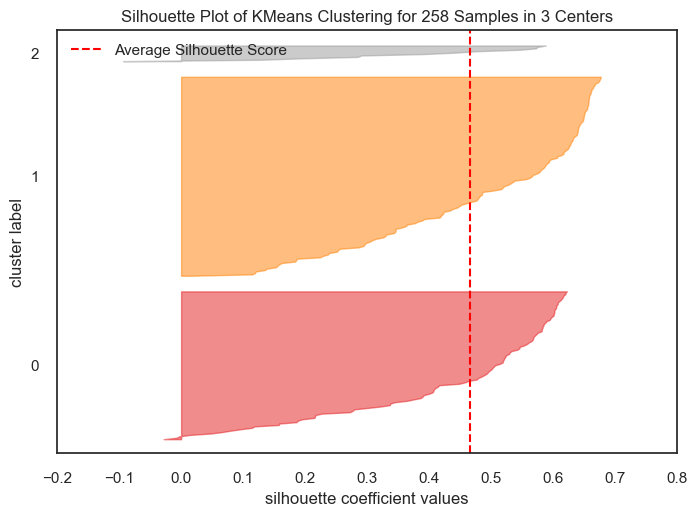

c:\anaconda\envs\ANLY501\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


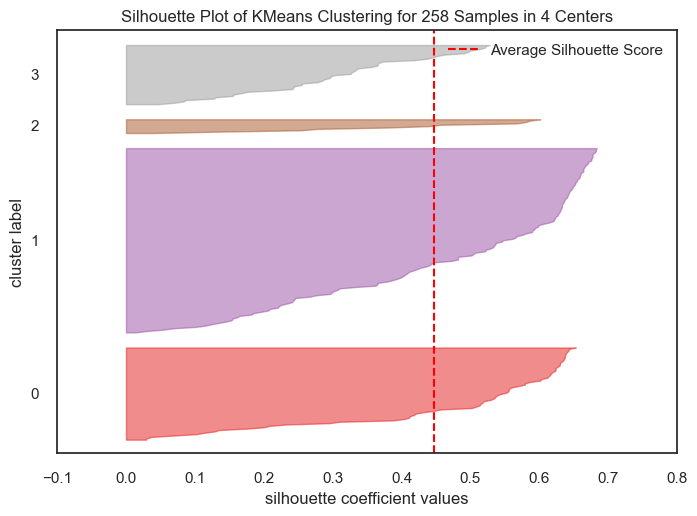

c:\anaconda\envs\ANLY501\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


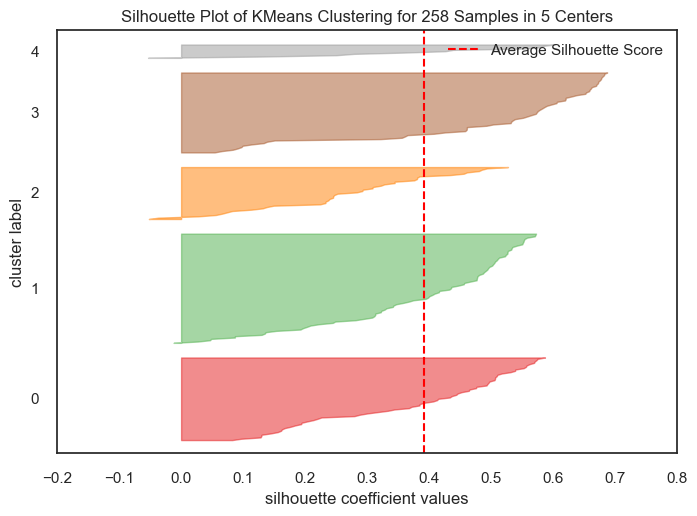

c:\anaconda\envs\ANLY501\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


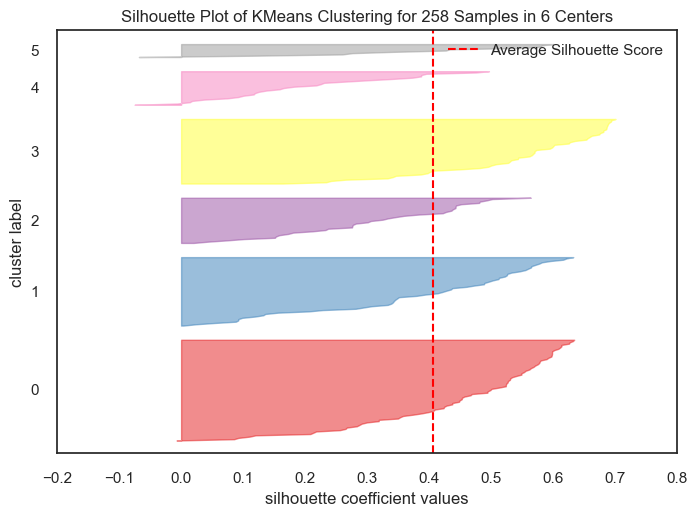

In [45]:
plot_silhouette(X, nmax=6)

### Final Results

Given the optimal hyperparameter, we cluster our data below with K-Means.


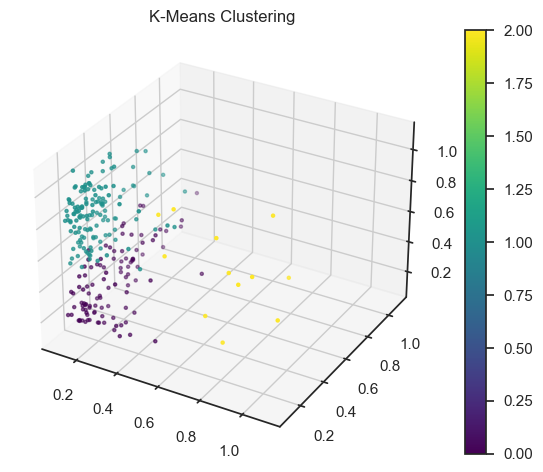

In [46]:
plot(X,opt_labels,"K-Means Clustering")

## DBSCAN

DBSCAN hyperparameter tuning is slightly different from K-Means and Hierarchical, which focuses on the number of clusters. Rather, DBSCAN parameter optimization relies on epsilon (EPS), which dictates how close points have to be to each other to be considered a part of a cluster, and min_samples, which dictates how many points are needed to form a cluster.

### Hyperparameter Tuning 

The plot below shows the number of data points in our data set and varying epsilon values. Epsilon in the plot below is labeled as "Distance," since epsilon is a measure of maximum distance between two points that are in the same cluster. Here, we're looking for the point of maximum curvature, which seems to be around eps=[0.15, 0.2].


Text(0, 0.5, 'Distance')

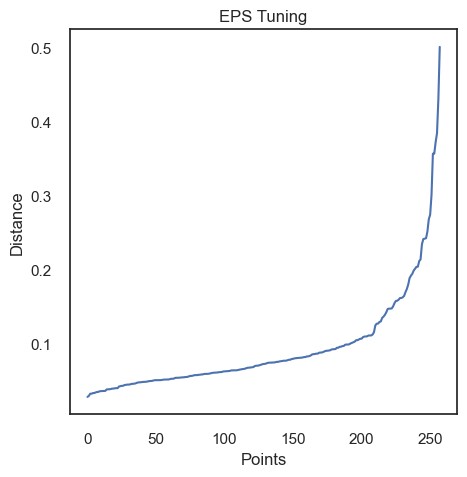

In [47]:
# Finding optimal EPS
## ref: https://towardsdatascience.com/how-to-use-dbscan-effectively-ed212c02e62
model = sklearn.neighbors.NearestNeighbors()
model = model.fit(X)

distances, indices = model.kneighbors(X)
distances = np.sort(distances[:,4], axis=0)

fig = plt.figure(figsize=(5, 5))
plt.plot(distances)
plt.title("EPS Tuning")
plt.xlabel("Points")
plt.ylabel("Distance")

To get the precise eps value, we perform the elbow (or knee, in this case) method to find the point of maximum curvature, which is around 0.147.


0.14666469356034625


<Figure size 500x500 with 0 Axes>

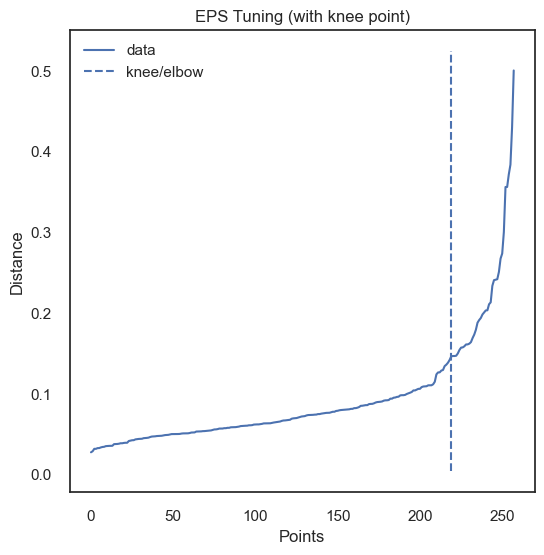

In [48]:
from kneed import KneeLocator

i = np.arange(len(distances))
knee = KneeLocator(i, distances, S=1, curve='convex', direction='increasing', interp_method='polynomial')

fig = plt.figure(figsize=(5, 5))
knee.plot_knee()
plt.title("EPS Tuning (with knee point)")
plt.xlabel("Points")
plt.ylabel("Distance")

eps = distances[knee.knee]
print(eps)

Below, we take the natural log of the total number of observations in our data set to get the number of min_samples.


In [49]:
# Finding optimal min_samples
## ref: https://stackoverflow.com/questions/12893492/choosing-eps-and-minpts-for-dbscan-r

min_samples = round(np.log(df.shape[0]))

### Final Results

We then create the DBSCAN model with our optimal parameters and get a respectable silhouette coefficient.


In [50]:
model = sklearn.cluster.DBSCAN(eps=eps, min_samples=min_samples).fit(X)
opt_labels=model.labels_
sklearn.metrics.silhouette_score(X,opt_labels)

0.34011471243009594

Given the optimal hyperparameters, we cluster our data below.


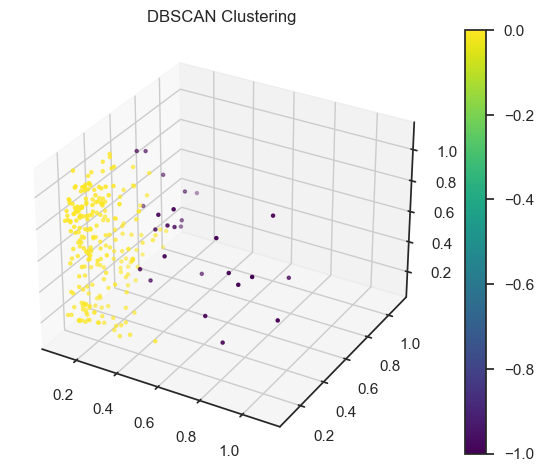

In [51]:
plot(X,opt_labels,'DBSCAN Clustering')

## Hierarchical (Agglomerative)

### Hyperparameter Tuning 

The plot below shows the silhouette coefficient for varying numbers of clusters. The silhouette coefficient peaks at k=4, which would be our optimal number of clusters.


OPTIMAL PARAMETER = 4
Silhouette Coefficient = 0.4346902641411452


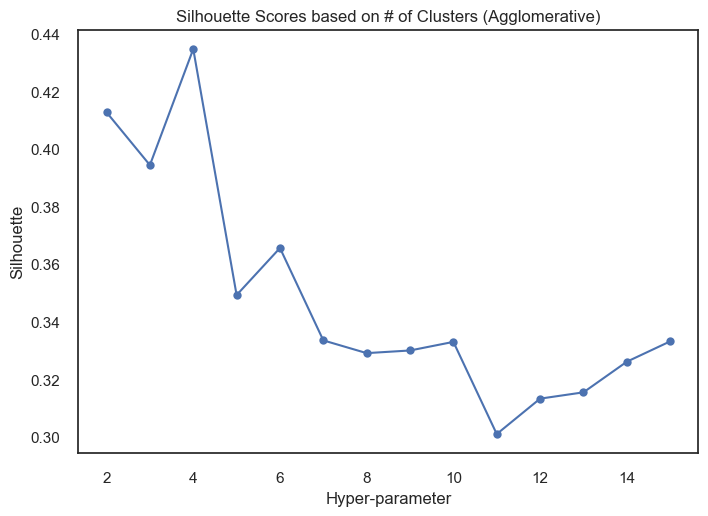

In [52]:
# AGGLOMERATIVE CLUSTERING
opt_labels=maximize_silhouette(X,algo="ag",i_plot=True)

### Final Results

Given the optimal hyperparameter, we cluster our data below with Agglomerative clustering.


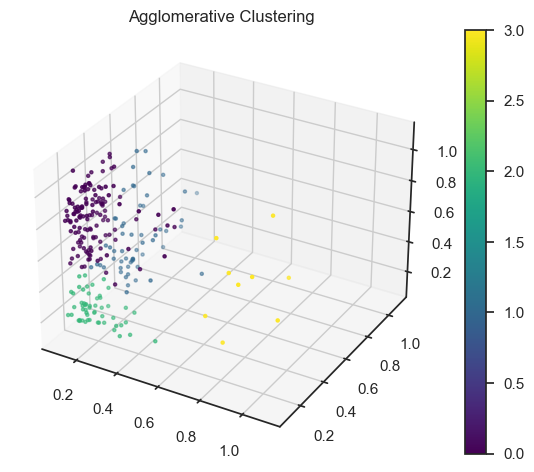

In [53]:
plot(X,opt_labels,'Agglomerative Clustering')

We can also represent the optimized Agglomerative clustering as a tree, with the purple line representing a "cutoff" point for the optimal number of clusters.


([], [])

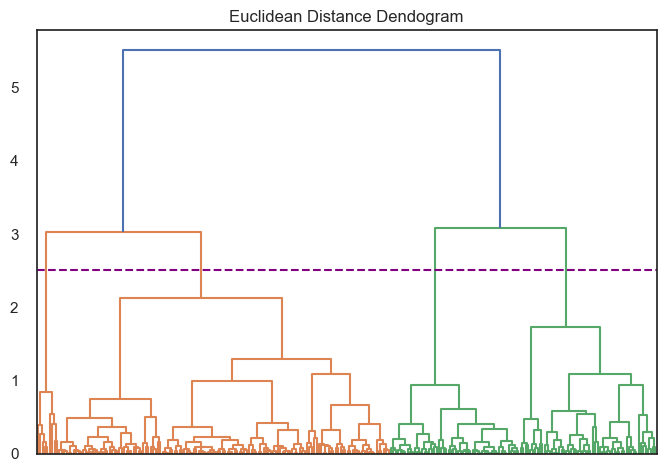

In [54]:
from scipy.cluster.hierarchy import dendrogram, linkage

link = linkage(X, method='ward')
dend = dendrogram(link)
plt.axhline(c='purple',linestyle='--', y=2.5) 
plt.title("Euclidean Distance Dendogram")
plt.xticks([]) # clear clutter from x axis ticks